In [2]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/suneha/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

In [4]:
df_movies = pd.read_csv(movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [5]:
df_movies.loc[:15,:]

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
5,6,Heat (1995)
6,7,Sabrina (1995)
7,8,Tom and Huck (1995)
8,9,Sudden Death (1995)
9,10,GoldenEye (1995)


In [8]:
df_ratings.loc[:5,:]

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0


In [6]:
# determining the number of unique users and movies in the dataset
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(num_users, num_items))

There are 610 unique users and 9724 unique movies in this dataset


In [7]:
# Getting the count of each type of rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [8]:
# clearly the rating of 0 is missing. Therefore, adding 0s
# df_ratings.shape[0] indicates the number of rows in ratings table(userid movieid rating) i.e., total other ratings
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt.head(2)


,count
0.0,5830804
0.5,1370


In [9]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

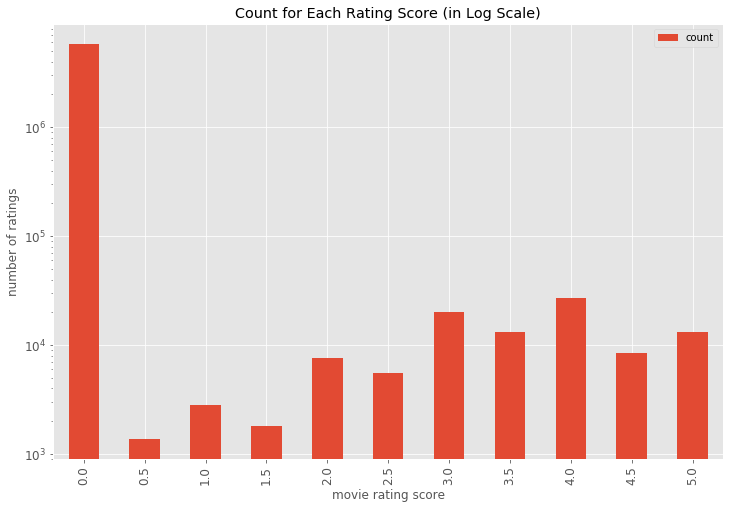

In [10]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [11]:
# get rating frequency for the movie
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()


,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

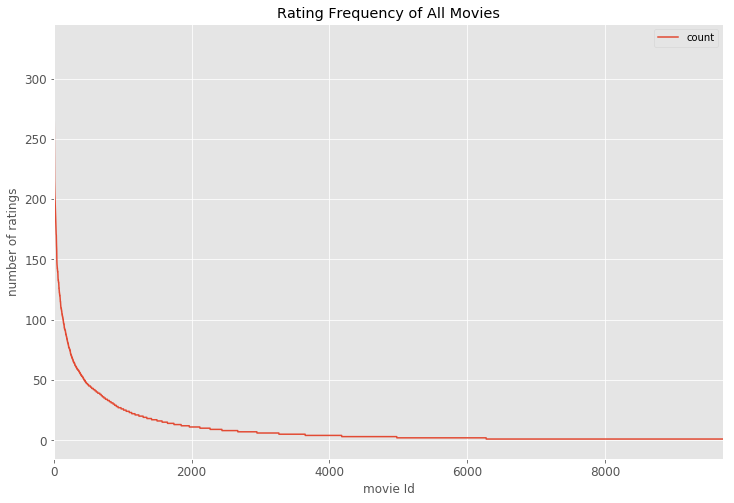

In [12]:
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

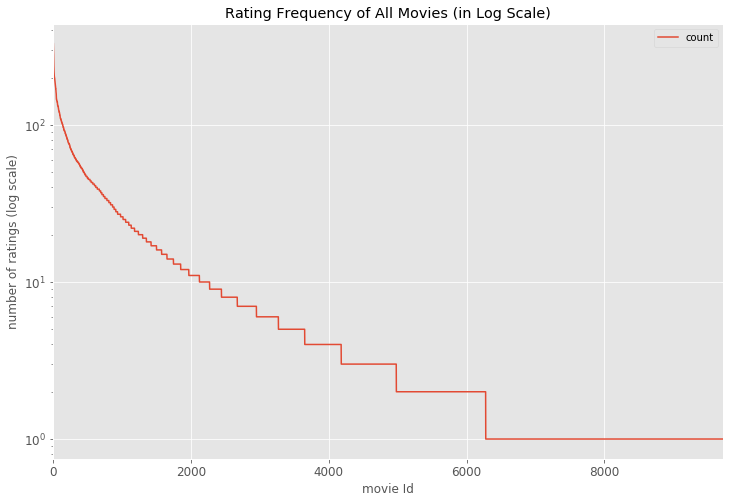

In [13]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [14]:
# filtering data to get only popular items i.e., movies with > 2 ratings
popularity_thres = 20
df_movies_cnt.query('count >= @popularity_thres').head()
# returns movies > 20 ratings

,count
movieId,
1,215
2,110
3,52
5,49
6,102


In [15]:
df_movies_cnt.query('count >= @popularity_thres').index
# gives index of all the movies>20 ratings

Int64Index([     1,      2,      3,      5,      6,      7,     10,     11,
                16,     17,
            ...
            122920, 122922, 134130, 134853, 139385, 148626, 152081, 164179,
            166528, 168252],
           dtype='int64', name='movieId', length=1297)

In [16]:
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
# df_ratings.movieId.isin(popular_movies) gives boolean list with true ony where movie id is present in popular_movies

In [17]:
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (67898, 3)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,181
2,23
3,22
4,138
5,41


Text(0, 0.5, 'number of ratings')

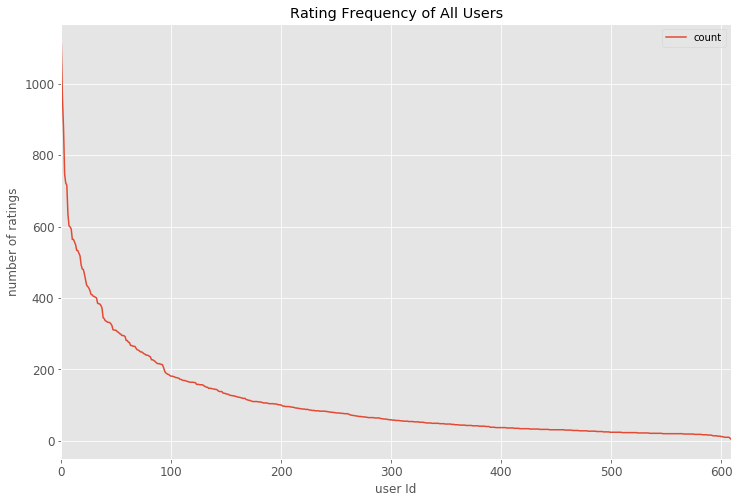

In [19]:
# plot rating frequency of all users
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [24]:
# filter data such that users who have rated > 50 movies are considered
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
#print(df_ratings_drop_users.head())

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (59960, 3)


In [26]:
df_ratings_drop_users

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
10,1,163,5.0


In [27]:
# pivot :  reshaping data(index->what field you want as rows, column->what fields you want as columns, values-> it will only show these fields)
# pivot_table : is used to summarize and aggregate data in dataframe
# pivot and create movie-user matrix
# Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. 
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index mapper = dictionary
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
# csr matrix is a compressed representation of the matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [28]:
movie_user_mat.loc[:10,:]

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
10,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [23]:
# “No space left on device” error while fitting Sklearn model 
# This problem occurs when shared memory is consumed and no I/O operation is permissible. This is a frustrating problem that occurs to most of the Kaggle users while fitting machine learning models.
#I overcame this problem by setting JOBLIB_TEMP_FOLDER variable using following code.

%env JOBLIB_TEMP_FOLDER=/tmp

# n_neighbors : Number of neighbors to use

# algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional
# ‘brute’ will use a brute-force search.

# metric : string or callable, default ‘minkowski’
# metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

# n_jobs : The number of parallel jobs to run for neighbors search. 
#  If set to -1, all CPUs are used.

# creating an instance of NearestNeighbours class
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [27]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
# fuzzywuzzy library where we can have a score out of 100, that denotes two string are equal by giving similarity index.
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
# ratio > 60 implies the presence of same words
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array.
    # [:0:-1] (slicing) reversing the list 
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [28]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.3652153015136719
2: Kung Fu Panda (2008), with distance of 0.36049962043762207
3: Inception (2010), with distance of 0.3561568856239319
4: Star Trek (2009), with distance of 0.3532044291496277
5: Up (2009), with distance of 0.3315470218658447
6: Iron Man 2 (2010), with distance of 0.30270129442214966
7: Avatar (2009), with distance of 0.29323285818099976
8: Avengers, The (2012), with distance of 0.2815631031990051
9: WALL·E (2008), with distance of 0.278143048286438
10: Dark Knight, The (2008), with distance of 0.27175241708755493
